## Incremental learning

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler

np.random.seed(1337) # for reproducibility


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings


def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    #Selection index due to using different window
    selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_thres_crossings = generate_crossings_data(dir_path, time_range, window = thres_win, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd, moving_thres_crossings), axis = 1)
    
    print("All data's shape: ", all_data.shape)
    
    %reset -f in
    
    return all_data, time_label

#####-------INCREMENTAL LEARNING IMPLEMENTATION-------######

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    model = models.Sequential()

    model.add(Dense(12, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=18))

    model.add(Dense(9,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(9,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(18,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')

    return model

def train(current_weights, X, time_axis, time_range, prev_dist, past_scaler):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    X_train = X[start_index:end_index]
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Scaler initiation
    scaler = past_scaler
    scaler.partial_fit(X_train)
    X_train = scaler.transform(X_train)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=20, verbose = 0)
    
    new_weights = model.get_weights()
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    dist = (np.mean(loss), np.std(loss))
    
    print("Finished training, distribution of the loss is: ", dist)
    
    return new_weights, dist, scaler

def trigger(current_weights, X, time_axis, time_range, prev_dist, scaler):
    
    print("Triggering for section: ", time_range)
    print("Using this distribution for trigger:", prev_dist)
    
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    X_test = X[start_index:end_index]
    X_test = scaler.transform(X_test) #Scale the current data
    
    time_test = time_axis[start_index:end_index]
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    #Quantify how much each data point is far away from the distribution
    sd_test_loss = (test_loss-prev_dist[0])/prev_dist[1] #prev_dist = (mean, sds) 
    
    #Plot the reconstruction loss just to check
    plt.figure(figsize=(20,2))
    plt.plot(time_test, sd_test_loss)
    plt.title("Reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Find the trigger time
    trigger_index = np.argmax(sd_test_loss > 50)
    
    if  trigger_index != 0:
        #Plot the triggered time
        plt.figure(figsize=(20,2))
        plt.plot(time_test, sd_test_loss, color = "firebrick")
        plt.title("Reconstruction loss on {}".format(time_range))
        plt.xlabel("Time [s]")
        
        #Trigger time
        plt.vlines(time_test[trigger_index], sd_test_loss.min(), sd_test_loss.max(), color = "blue", linestyles = "dashed", label = "Trigger time")
        plt.legend(loc = "upper left")
        plt.show()
        
        return time_test[trigger_index]
    
    else:
        return None
    
    return trigger_time
    

def simulation(dir_path, section_size, time_range):
    
    #Load data and create the model
    X, time_axis = generate_data(dir_path, time_range = time_range, window = 2000, step = 10)
    
    #For updating model
    current_weights = None
    new_weights = None
    
    #For keeping track of distribution history
    prev_dist = None
    dist = None
    
    #Keeping track of scaler after training
    past_scaler = None
    
    #Create a model
    model = create_model()
    
    #Initialize the scaler
    scaler = MinMaxScaler()
    
    #Calculate number of sections
    num_section = int(abs(time_range[0])/section_size)
    print("Number of sections:", num_section)
    
    #Sequentially go through the data
    for i in range(num_section):
        
        print("Entering sections: ", (-section_size*(num_section - i), -section_size*(num_section - i - 1)))
        print("-------->")
        
        if i == 0:
            continue
        elif i == 1:
            #Train on the first segment
            time_range = (None, -section_size*(num_section - i))
            new_weights, dist, past_scaler = train(current_weights, X, time_axis, time_range, prev_dist, scaler)
        else:
            #Set the model to newly trained model
            model.set_weights(new_weights)
            
            #Set previous distrubution to the newly trained disttribution
            prev_dist = dist
            scaler = past_scaler #Set the scaler as well
            
            #Selecting appropriate time range for training and triggering
            train_time_range = (-section_size*(num_section - i + 1), -section_size*(num_section - i))
            trigger_time_range = (-section_size*(num_section - i), -section_size*(num_section - i - 1))
            
            #Train and predict simutaneously
            new_weights, dist, past_scaler = train(current_weights, X, time_axis, train_time_range, prev_dist, scaler)
            trigger_time = trigger(current_weights, X, time_axis, trigger_time_range, prev_dist, scaler)
            
            if trigger_time:
                print("Triggered at: ", trigger_time)
                return trigger_time
        
        print("<--------")

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (247500, 18)
Flushing input history
Number of sections: 5
Entering sections:  (-25, -20)
-------->
Entering sections:  (-20, -15)
-------->
Training for section:  (None, -20)
Finished training, distribution of the loss is:  (0.05244647276682028, 0.024796879837195702)
<--------
Entering sections:  (-15, -10)
-------->
Training for section:  (-20, -15)
Finished training, distribution of the loss is:  (0.044328261060063996, 0.017127771381325516)
Triggering for section:  (-15, -10)
Using this distribution for trigger: (0.05244647276682028, 0.

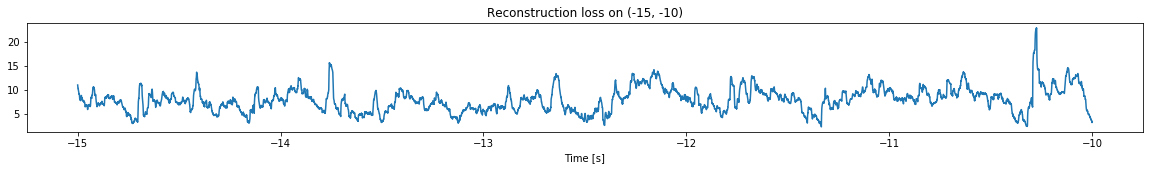

<--------
Entering sections:  (-10, -5)
-------->
Training for section:  (-15, -10)
Finished training, distribution of the loss is:  (0.051181990971688504, 0.023752133525640207)
Triggering for section:  (-10, -5)
Using this distribution for trigger: (0.044328261060063996, 0.017127771381325516)


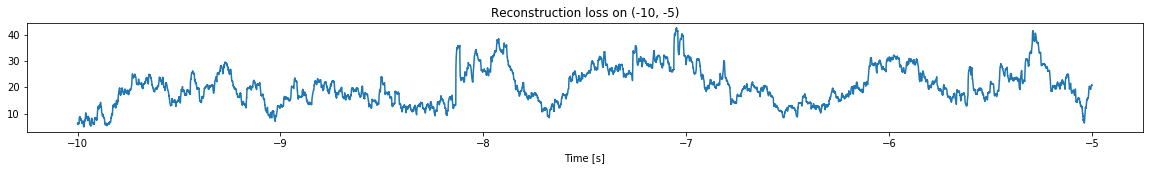

<--------
Entering sections:  (-5, 0)
-------->
Training for section:  (-10, -5)
Finished training, distribution of the loss is:  (0.04282881926975967, 0.015529471822639765)
Triggering for section:  (-5, 0)
Using this distribution for trigger: (0.051181990971688504, 0.023752133525640207)


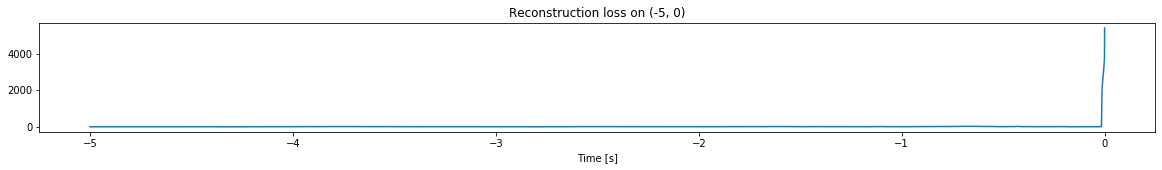

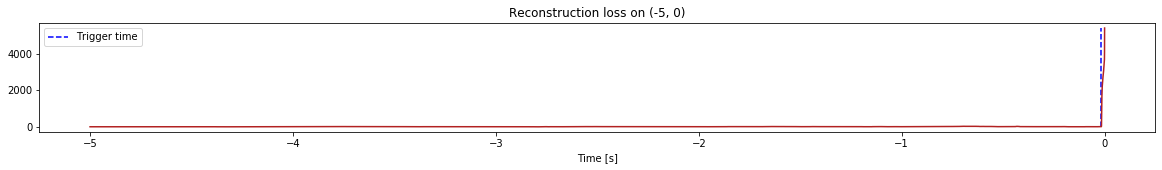

Triggered at:  -0.0155


-0.0155

In [3]:
simulation("./data/Ramp22/", 5, (-25,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (497500, 18)
Flushing input history
Number of sections: 10
Entering sections:  (-50, -45)
-------->
Entering sections:  (-45, -40)
-------->
Training for section:  (None, -45)
Finished training, distribution of the loss is:  (0.04827556588705887, 0.022322007438172035)
<--------
Entering sections:  (-40, -35)
-------->
Training for section:  (-45, -40)
Finished training, distribution of the loss is:  (0.05576964491477757, 0.022825281510641428)
Triggering for section:  (-40, -35)
Using this distribution for trigger: (0.04827556588705887, 0.

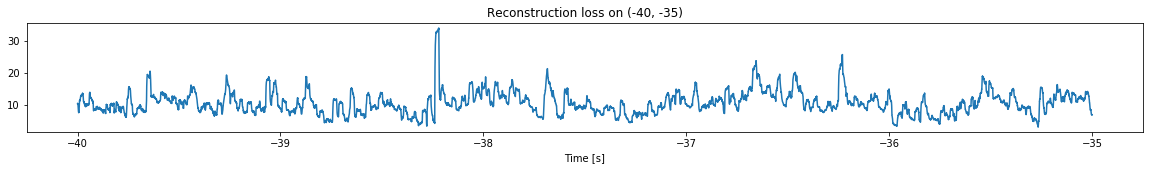

<--------
Entering sections:  (-35, -30)
-------->
Training for section:  (-40, -35)
Finished training, distribution of the loss is:  (0.04694772833024429, 0.019276829180446528)
Triggering for section:  (-35, -30)
Using this distribution for trigger: (0.05576964491477757, 0.022825281510641428)


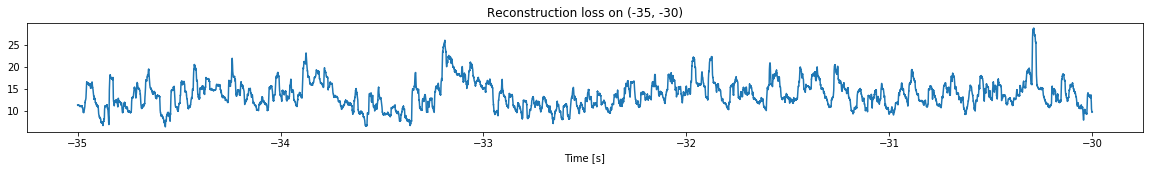

<--------
Entering sections:  (-30, -25)
-------->
Training for section:  (-35, -30)
Finished training, distribution of the loss is:  (0.045997973083957706, 0.016818142894006637)
Triggering for section:  (-30, -25)
Using this distribution for trigger: (0.04694772833024429, 0.019276829180446528)


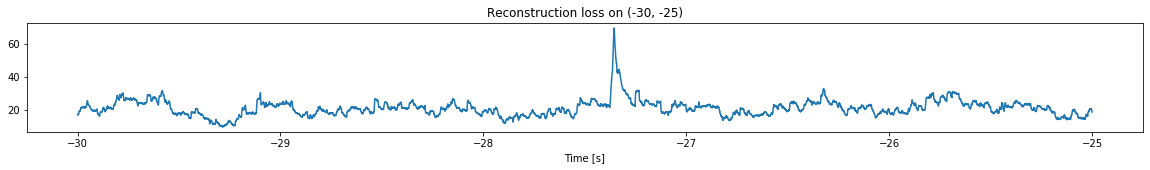

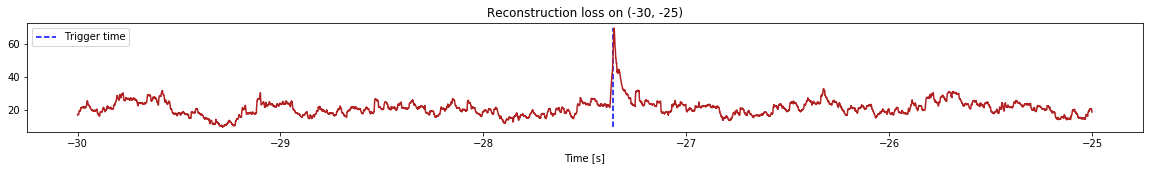

Triggered at:  -27.361599


-27.361599

In [4]:
simulation("./data/Ramp22/", 5, (-50,0))